# Machine Learning 🤖

In this notebook, I will be demonstrating the use of clustering methods in unsupervised learning to group websites based on similarity in accessibility violation patterns in order to identify **high-risk domains**. This predictive modeling task helps surface latent structure in large-scale audit data where no ground-truth risk labels exist, making unsupervised learning an appropriate analytical approach.

By clustering websites according to metrics such as violation severity, frequency, and distribution across accessibility principles, we can identify groups of domains that exhibit systematically higher accessibility risk. These clusters provide a data-driven way to prioritize remediation efforts, especially for domain categories that disproportionately contribute to serious or recurring violations.

To support interpretation, cluster-level risk scores are computed by aggregating violation intensity within each cluster. These risk scores are then propagated back to individual websites and domain categories, enabling multi-level analysis: from individual web domains, to clusters, to broader domain types. Dimensionality reduction techniques such as PCA are used to visualize the distribution of websites in feature space, while risk-weighted aggregations highlight which domain categories contribute most to overall accessibility risk.

Together, this approach transforms raw violation metrics into actionable insights, allowing stakeholders to move from isolated accessibility errors toward systemic risk identification and prioritization.

In [1]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette, fcluster

import matplotlib.pyplot as plt
import seaborn as sns

print("✅ ML Jupyter environment ready")

✅ ML Jupyter environment ready


> Access cleaned data made from previous notebook

In [2]:
df = pd.read_csv("../Data/Cleaned_Access_to_Tech_Dataset.csv")
df.shape

(3524, 18)

In [3]:
df.head(5)

,id,web_URL_id,domain_category,web_URL,scrape_status,html_file_name,html_file_path,violation_count,violation_name,violation_score,violation_description,violation_description_url,affected_html_elements,violation_category,violation_impact,wcag_reference,supplementary_information,web_domain
0,700_0,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,color-contrast-enhanced,4,Ensures the contrast between foreground and ba...,https://dequeuniversity.com/rules/axe/4.4/colo...,"<a href=\/buy-from-government\"">How to buy fro...",Layout,serious,['1.4.6 Contrast (Enhanced)'],"{'fgColor': '#00bde3', 'bgColor': '#112f4e', '...",www.usa.gov
1,700_1,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-banner-is-top-level,3,Ensures the banner landmark is at top level,https://dequeuniversity.com/rules/axe/4.4/land...,"<div class=\usa-banner__header\"" role=\""banner...",Syntax,moderate,['1.3.1 Info and Relationships'],"<div class=\usa-banner__header\"" role=\""banner...",www.usa.gov
2,700_2,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-no-duplicate-banner,3,Ensures the document has at most one banner la...,https://dequeuniversity.com/rules/axe/4.4/land...,<header class=\usa-header usa-header--extended...,Syntax,moderate,['1.3.1 Info and Relationships'],11 <header> or role='banner' elements found:\n...,www.usa.gov
3,700_3,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-unique,3,Landmarks should have a unique role or role/la...,https://dequeuniversity.com/rules/axe/4.4/land...,<header class=\usa-header usa-header--extended...,Syntax,moderate,['1.3.1 Info and Relationships'],Role 'search' found 2 times:\n<form accept-cha...,www.usa.gov
4,701_0,701,Government and Public Services,https://www.usa.gov/benefits,scraped,www_usa_gov_benefits.html,/content/workspace/FullPipeline/html_pages_asy...,4,color-contrast-enhanced,4,Ensures the contrast between foreground and ba...,https://dequeuniversity.com/rules/axe/4.4/colo...,"<a href=\/food-help\"">Learn about food assista...",Layout,serious,['1.4.6 Contrast (Enhanced)'],"{'fgColor': '#00bde3', 'bgColor': '#112f4e', '...",www.usa.gov


## Preprocessing 🗳️

We will first aggregate raw accessibility violation data at the web-domain level to create severity-based features used for clustering. For each website, we will summarize:
- Median violation score `violation_score_median`: Represents the typical severity of accessibility violations for a website, reducing the influence of extreme outliers.
- 95th percentile violation score `violation_score_p95`: Captures near–worst-case violation severity, highlighting sites with consistently severe issues even if they are not maximal.
- Maximum violation score `violation_score_max`: Identifies the single most severe accessibility violation observed for each website.
- High-impact proportion `pct_critical_impact`: Estimates overall severity risk by combining the share of critical and serious violations.

In [4]:
severity_features = (
    df.groupby("web_domain")
      .agg(
          violation_score_median=("violation_score", "median"),
          violation_score_p95=("violation_score", lambda x: x.quantile(0.95)),
          violation_score_max=("violation_score", "max"),
          pct_critical_impact=("violation_impact",
                              lambda x: ((x == "critical").mean() + (x == "serious").mean()) / 2)
      )
)
severity_features.sample(10)

,violation_score_median,violation_score_p95,violation_score_max,pct_critical_impact
web_domain,,,,
www.metro.co.uk,3.0,5.00,5,0.187500
www.databricks.com,4.0,4.00,4,0.500000
www.webmd.com,4.0,5.00,5,0.285714
www.health.harvard.edu,3.0,3.90,4,0.250000
www.sba.gov,4.0,4.00,4,0.500000
www.mathworks.com,3.0,3.90,4,0.166667
www.learn.k20center.ou.edu,3.0,4.60,5,0.222222
www.nal.usda.gov,3.5,3.95,4,0.250000
www.snapdeal.com,3.0,3.90,4,0.166667


In [5]:
page_violation_counts = (
    df.groupby(["web_domain", "web_URL"])
      .size()
      .rename("violations_per_page")
      .reset_index()
)
page_violation_counts.sample(10)

,web_domain,web_URL,violations_per_page
337,www.nrl.navy.mil,https://www.nrl.navy.mil,6
114,www.dell.com,https://www.dell.com,3
343,www.nytimes.com,https://www.nytimes.com/,6
402,www.runtastic.com,https://www.runtastic.com,2
77,www.canvas.net,https://www.canvas.net,5
369,www.pbs.org,https://www.pbs.org/newshour,9
117,www.dequeuniversity.com,https://dequeuniversity.com/rules/axe/4.10/ari...,3
295,www.nature.com,https://www.nature.com,2
1,www.abc.net.au,https://www.abc.net.au/news,4
41,www.arstechnica.com,https://arstechnica.com/security/,9


We will then summarize accessibility violation volume at the website level by aggregating page-level violation counts. For each web domain, we will compute:
- Median violations per page `violations_per_page_median`: Represents the typical number of accessibility violations found on a page within each website.
- 90th percentile violations per page `violations_per_page_p90`: Captures high–violation pages while reducing sensitivity to extreme outliers.


In [6]:
volume_features = (
    page_violation_counts.groupby("web_domain")
    .agg(
        violations_per_page_median=("violations_per_page", "median"),
        violations_per_page_p90=("violations_per_page",
                                 lambda x: x.quantile(0.90))
    )
)
volume_features.sample(10)

,violations_per_page_median,violations_per_page_p90
web_domain,,
www.cisa.gov,5.0,5.0
www.bea.gov,5.0,5.0
www.opm.gov,8.0,8.0
www.bookwidgets.com,7.0,7.0
www.producthunt.com,3.0,3.0
www.thestar.com,11.0,11.0
www.dailymotion.com,4.5,4.9
www.abc.net.au,4.0,4.0
www.forbes.com,6.0,6.0


In [7]:
violation_category_dist = (
    df.assign(count=1)
      .pivot_table(
          index="web_domain",
          columns="violation_category",
          values="count",
          aggfunc="sum",
          fill_value=0
      )
      .rename_axis(None, axis=1)
)

violation_category_dist.sample(10)

,Layout,Semantic,Syntax
web_domain,,,
www.medicaid.gov,1,0,3
www.hbomax.com,0,0,4
www.bbc.com,8,0,14
www.netflix.com,2,0,5
www.zeropointhealers.com,1,0,1
www.scholar.google.com,2,0,4
www.wetv.vip,2,0,5
www.collegevine.com,2,0,6
www.globalnews.ca,1,0,2


In [8]:
def map_wcag_principle(ref):
    if "1." in ref:
        return "perceivable"
    if "2." in ref:
        return "operable"
    if "3." in ref:
        return "understandable"
    if "4." in ref:
        return "robust"
    return "unknown"

df["wcag_principle"] = df["wcag_reference"].astype(str).apply(map_wcag_principle)

This step interprets each accessibility violation in terms of the [WCAG principle](https://www.w3.org/TR/UNDERSTANDING-WCAG20/intro.html) it affects, rather than focusing on the specific technical rule that was violated. Mapping violations to the four core principles: 
- Perceivable
- Operable
- Understandable
- Robust

> By accounting this into our embeddings, we are building the predictive models in compliance to these principles, making it an important signal to our models!

In [9]:
wcag_dist = (
    df.assign(count=1)
      .pivot_table(
          index="web_domain",
          columns="wcag_principle",
          values="count",
          aggfunc="sum",
          fill_value=0
      )
      .div(df.assign(count=1)
              .pivot_table(
                  index="web_domain",
                  columns="wcag_principle",
                  values="count",
                  aggfunc="sum",
                  fill_value=0
              ).sum(axis=1), axis=0)  # Calculate row sums first, then divide
      .rename_axis(None, axis=1)
)

wcag_dist.sample(10)

,operable,perceivable,understandable
web_domain,,,
www.economist.com,0.250000,0.750000,0.0
www.getyourrefund.org,0.000000,1.000000,0.0
www.bioconductor.org,0.000000,1.000000,0.0
www.coursera.org,0.000000,1.000000,0.0
www.strava.com,0.166667,0.833333,0.0
www.ivi.ru,0.200000,0.800000,0.0
www.techcrunch.com,0.000000,1.000000,0.0
www.tes.com,0.000000,1.000000,0.0
www.medicaid.gov,0.250000,0.750000,0.0


> HTML code is also here for a reason. We can utilize these pieces of code to extract further signals to improve our models!

In [10]:
def extract_html_flags(s):
    s = str(s).lower()
    return {
        "img": int("img" in s),
        "input": int("input" in s),
        "button": int("button" in s),
        "form": int("form" in s),
        "nav": int("nav" in s),
    }

html_flags = (
    df["affected_html_elements"]
    .apply(extract_html_flags)
    .apply(pd.Series)
)

html_flags["web_domain"] = df["web_domain"]

html_element_dist = html_flags.groupby("web_domain").mean()

html_element_dist.sample(10)

,img,input,button,form,nav
web_domain,,,,,
www.latex-project.org,0.000000,0.250,0.250000,0.000000,0.000000
www.merckmanuals.com,0.000000,0.000,0.500000,0.000000,0.000000
www.thestar.com,0.090909,0.000,0.181818,0.090909,0.454545
www.libretexts.org,0.142857,0.000,0.428571,0.285714,0.142857
www.tv.youtube.com,0.125000,0.125,0.250000,0.125000,0.250000
www.huffpost.com,0.000000,0.000,0.500000,0.125000,0.375000
www.fedramp.gov,0.000000,0.000,0.250000,0.000000,0.000000
www.epa.gov,0.000000,0.000,1.000000,1.000000,0.000000
www.garmin.com,0.250000,0.000,0.000000,0.000000,0.000000


> We conclude the **feature engineering** step by combining the changes we made into one data frame we can work with and feed into our models!

In [11]:
domain_features = (
    severity_features
    .join(volume_features)
    .join(violation_category_dist)
    .join(wcag_dist)
    .join(html_element_dist)
)

domain_features.sample(10)

,violation_score_median,violation_score_p95,violation_score_max,pct_critical_impact,violations_per_page_median,violations_per_page_p90,Layout,Semantic,Syntax,operable,perceivable,understandable,img,input,button,form,nav
web_domain,,,,,,,,,,,,,,,,,
www.mxplayer.in,4.0,5.00,5,0.333333,6.0,6.0,3,0,3,0.000000,1.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000
www.jd.com,4.0,4.60,5,0.277778,9.0,9.0,2,0,7,0.222222,0.777778,0.000000,0.444444,0.111111,0.222222,0.000000,0.000000
www.qvc.com,3.0,4.00,4,0.200000,5.0,5.0,0,0,5,0.400000,0.600000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000
www.vudu.com,3.0,4.70,5,0.125000,4.0,4.0,0,0,4,0.250000,0.750000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
www.lightinthebox.com,3.0,4.40,5,0.192308,13.0,13.0,2,0,11,0.153846,0.769231,0.076923,0.230769,0.230769,0.153846,0.076923,0.307692
www.headspace.com,3.5,3.95,4,0.250000,2.0,2.0,1,0,1,0.500000,0.500000,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000
www.uopeople.edu,3.0,4.40,5,0.230769,13.0,13.0,2,0,11,0.076923,0.923077,0.000000,0.153846,0.000000,0.230769,0.076923,0.076923
www.soulcycle.com,4.0,4.80,5,0.300000,5.0,5.0,2,0,3,0.000000,1.000000,0.000000,0.000000,0.600000,0.400000,0.800000,0.000000
www.coursera.org,3.0,4.00,4,0.200000,45.0,45.0,9,0,36,0.000000,1.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.200000


> Always standardize before feeding data into the model!

In [12]:
X = StandardScaler().fit_transform(domain_features)
X.shape

(464, 17)

> Let's also make sure we didn't lose any entires along the way!

In [13]:
X.shape[0] == df['web_domain'].nunique()

True

## Unsupervised Learning

Unsupervised learning is a machine learning approach in which models are applied to unlabeled data to discover underlying structure, patterns, or relationships without predefined outcomes. Instead of predicting known targets, unsupervised methods identify similarities, groupings, or latent dimensions within the data, making them well suited for exploratory analysis when ground truth labels are unavailable. Common techniques include clustering and dimensionality reduction, which help reveal hidden organization, summarize complex datasets, and generate insights that can guide further analysis or downstream modeling. This will be especially relevant in clustering tasks when we don't have defined classifications to work with! 

### k-means

K-means is a widely used clustering algorithm that partitions data into a fixed number of groups by minimizing the distance between data points and their assigned cluster centroids. It is a great algorithm to start with because it is simple to understand, computationally efficient, and easy to implement, even on large datasets. K-means provides clear, interpretable results that make it useful for exploratory analysis, helping reveal broad structure in the data before applying more complex or specialized clustering methods.

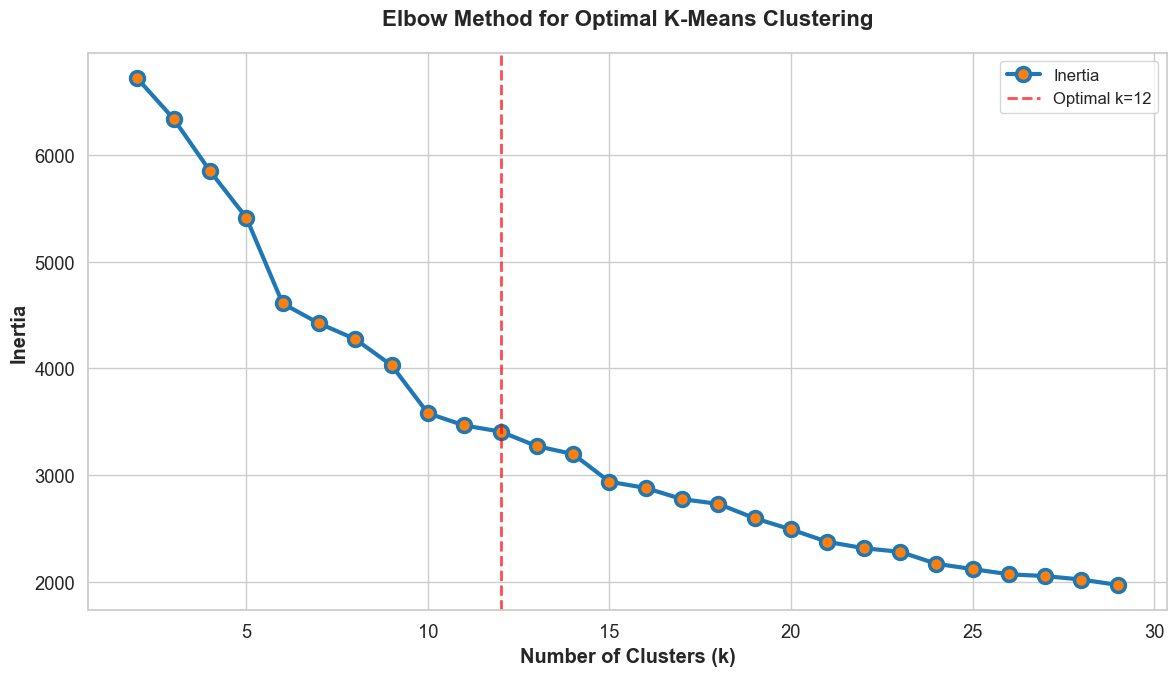

In [14]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

inertias = []
K_range = range(2, 30)
for k in K_range:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(12, 7))
plt.plot(K_range, inertias, marker='o', linewidth=3, markersize=10, 
         color='#1f77b4', markerfacecolor='#ff7f0e', 
         markeredgewidth=2.5, markeredgecolor='#1f77b4',
         label='Inertia')
plt.xlabel("Number of Clusters (k)", fontweight='bold')
plt.ylabel("Inertia", fontweight='bold')
plt.title("Elbow Method for Optimal K-Means Clustering", 
          fontsize=16, fontweight='bold', pad=20)
k_optimal = 12
plt.axvline(x=k_optimal, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal k={k_optimal}')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


The Elbow Method is a useful heuristic for determining an appropriate number of clusters by identifying the point at which adding more clusters yields diminishing returns in model improvement. As the number of clusters increases, the within-cluster variance naturally decreases, but after a certain point the reduction becomes marginal, forming an “elbow” in the curve. Similar to supervised learning model selection, the Elbow Method helps balance model complexity and explanatory power, preventing overfitting while ensuring that meaningful structure in the data is still captured.

In [15]:
k = 12
kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
labels = kmeans.fit_predict(X)

clustered = domain_features.copy()
clustered['kmeans_cluster'] = labels
clustered['kmeans_cluster'].sample(5)

web_domain
www.canvas.net                11
www.luminarypodcasts.com       3
www.paramountplus.com          3
www.learn.k20center.ou.edu     3
www.menshealth.com            10
Name: kmeans_cluster, dtype: int32

The optimal k according to the Elbow Method is 12 clusters. However, the result below highlights a key limitation of k-means: its assumption that clusters are spherical and mutually exclusive, meaning each data point must belong to exactly one cluster and cluster boundaries are defined purely by distance to a centroid. Noteably, some clusters only contains 1-digit of data points which makes the clusters exemplary outliers.

In [16]:
cluster_sizes = clustered["kmeans_cluster"].value_counts().sort_index()
cluster_sizes

kmeans_cluster
0      12
1      17
2       5
3     135
4      11
5      88
6      25
7      47
8       1
9       1
10     68
11     54
Name: count, dtype: int64

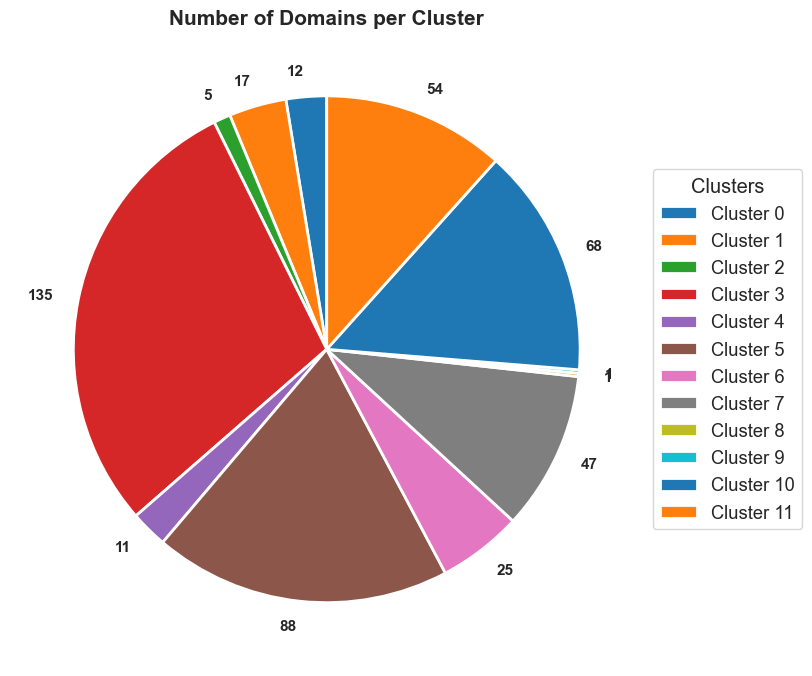

In [17]:
cluster_sizes = clustered["kmeans_cluster"].value_counts().sort_index()

plt.figure(figsize=(12, 7))

legend_labels = [f"Cluster {i}" for i in cluster_sizes.index]

wedges, texts = plt.pie(
    cluster_sizes.values,
    labels=[str(v) for v in cluster_sizes.values],
    startangle=90,
    labeldistance=1.1,
    textprops={'fontsize': 11, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

plt.legend(
    wedges, 
    legend_labels, 
    title="Clusters", 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.title("Number of Domains per Cluster", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


> Both visualizations above and below has proven that k-means might not be the best approach for this data, there are definitely better ways to do this!

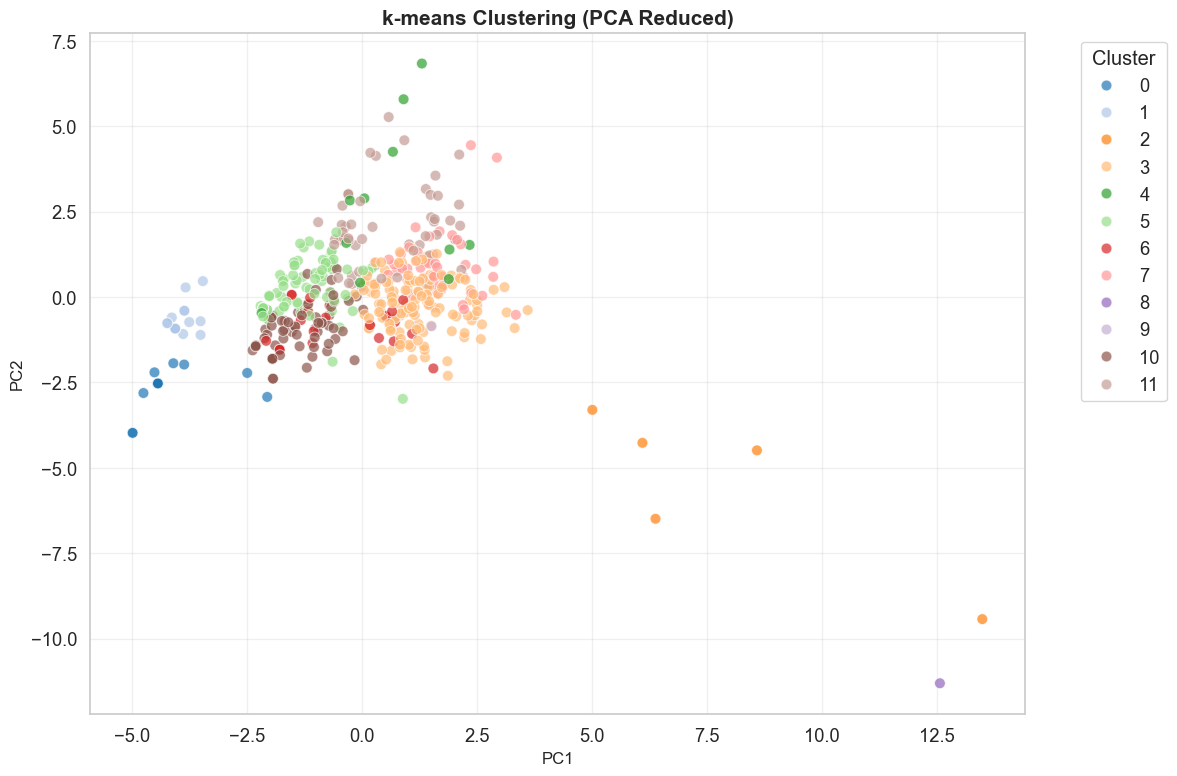

In [18]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

kmeans_pca_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
kmeans_pca_plot['Cluster'] = clustered['kmeans_cluster'].values

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=kmeans_pca_plot, 
    x='PC1', 
    y='PC2', 
    hue='Cluster', 
    palette='tab20', 
    s=60, 
    alpha=0.7,
    edgecolor='w'
)

plt.title('k-means Clustering (PCA Reduced)', fontsize=15, fontweight='bold')
plt.xlabel(f'PC1', fontsize=12)
plt.ylabel(f'PC2', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Agglomerative Clustering

Agglomerative clustering addresses several limitations of k-means by building clusters hierarchically rather than forcing a fixed, centroid-based partition. It begins with each data point as its own cluster and iteratively merges the most similar clusters, allowing for more flexible cluster shapes and relationships. Because it does not assume spherical or equally sized clusters and does not require specifying the number of clusters upfront, agglomerative clustering is well suited for exploratory analysis and provides additional insight through its hierarchical structure, which can be visualized using a dendrogram.

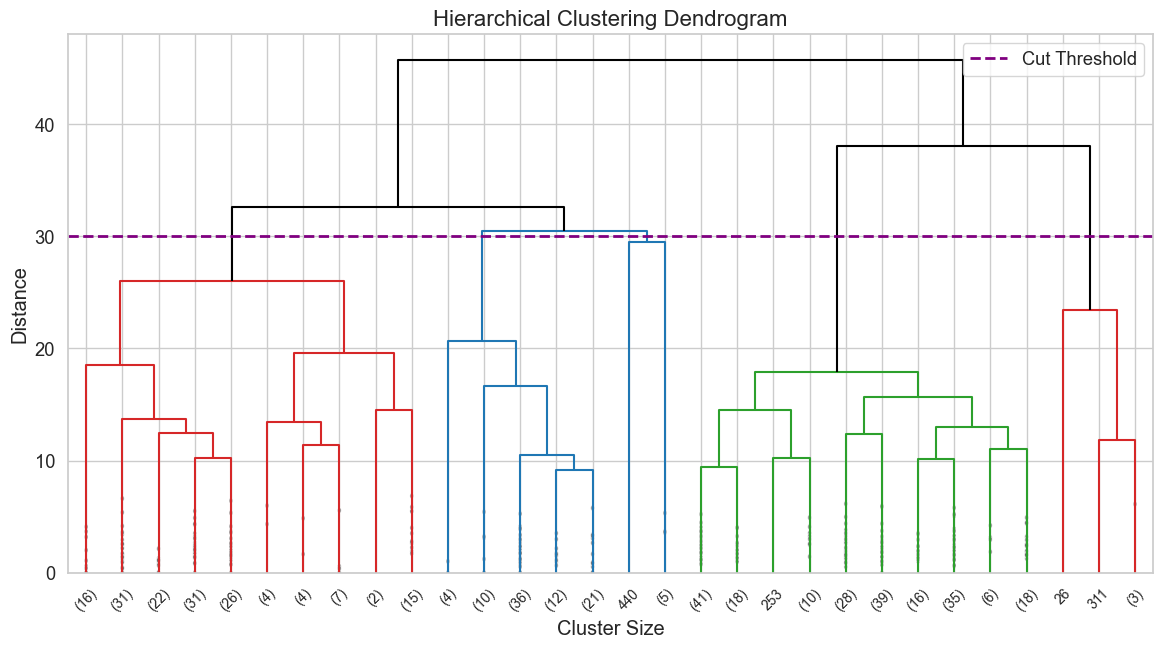

In [19]:
Z = linkage(X, method="ward")

set_link_color_palette(['#D62728', '#1F77B4', '#2CA02C'])

plt.figure(figsize=(14, 7))
dendrogram(
    Z,
    truncate_mode="lastp",  
    p=30,                   
    leaf_rotation=45,
    leaf_font_size=10,
    show_contracted=True,
    above_threshold_color='black'  
)

plt.axhline(
    y=30, 
    c='purple',       
    lw=2,          
    linestyle='--', 
    alpha=1.0,     
    label='Cut Threshold'
)
plt.legend(loc='upper right')

plt.title("Hierarchical Clustering Dendrogram", fontsize=16)
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

A dendrogram shows how clusters merge as similarity decreases, making it easier to choose a reasonable number of clusters. Drawing a horizontal line at `k = 5` cuts the tree before major merges occur, preserving meaningful groupings while avoiding over-combination. The number of clusters is determined by counting the branches the line crosses, and the line is typically placed where there is a clear gap between merge distances.

In [20]:
k = 5
agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
agg_labels = agg.fit_predict(X)

clustered["agg_cluster"] = agg_labels

In [21]:
clustered["agg_cluster"].value_counts().sort_index()

agg_cluster
0      6
1    158
2    212
3      5
4     83
Name: count, dtype: int64

> Noteably, we are working with a lot less clusters this time! However, 2 out of the 5 clusters still show outlier tendencies, this may be a counter-argument for **k-means**' limitations in this setting and more on the nature of this data.

In [22]:
verdict = domain_features.merge(clustered[['kmeans_cluster', 'agg_cluster']], on='web_domain', how='left').merge(df[['web_domain', 'domain_category']], on='web_domain', how='left')
verdict.columns, verdict.shape

(Index(['web_domain', 'violation_score_median', 'violation_score_p95',
        'violation_score_max', 'pct_critical_impact',
        'violations_per_page_median', 'violations_per_page_p90', 'Layout',
        'Semantic', 'Syntax', 'operable', 'perceivable', 'understandable',
        'img', 'input', 'button', 'form', 'nav', 'kmeans_cluster',
        'agg_cluster', 'domain_category'],
       dtype='str'),
 (3524, 21))

After forming the clusters, the next step is to interpret what each cluster represents. To do this, we consolidate the engineered features into aggregated summaries at the cluster level, allowing us to characterize and compare clusters based on their overall accessibility risk profiles.

In [23]:
cluster_summary = (
    verdict.groupby('agg_cluster')
      .agg({
          'violation_score_median': 'median',
          'violation_score_p95': 'median',
          'violations_per_page_median': 'median',
          'pct_critical_impact': 'mean',
          'operable': 'mean',
          'perceivable': 'mean',
          'understandable': 'mean',
          'button': 'mean',
          'input': 'mean',
          'form': 'mean',
          'nav': 'mean'
      })
)

cluster_summary

,violation_score_median,violation_score_p95,violations_per_page_median,pct_critical_impact,operable,perceivable,understandable,button,input,form,nav
agg_cluster,,,,,,,,,,,
0,4.0,5.0,1.0,0.310811,0.297297,0.594595,0.108108,0.040541,0.135135,0.067568,0.067568
1,3.0,4.0,5.0,0.236392,0.048212,0.951788,0.000000,0.241058,0.057543,0.150855,0.175739
2,4.0,5.0,8.0,0.278343,0.126938,0.869671,0.003391,0.197674,0.066376,0.129845,0.150194
3,4.0,5.0,9.0,0.275815,0.154891,0.845109,0.000000,0.266304,0.067935,0.144022,0.059783
4,3.0,4.0,5.0,0.198667,0.344000,0.656000,0.000000,0.109333,0.018667,0.056000,0.077333


## Risk Profiling ☣️

> How do we quantify risk? What counts as high-risk domains? These are questions we have to answer through careful engineering backed by thoughtful and thorough justifications! Below, I created my own risk formula and assigned more weight to attributes that I believe are more important.

$$
\text{Risk Score} = 0.30 \cdot \text{Median Score} + 0.25 \cdot \text{Score}_{p95} + 0.20 \cdot \% \text{Critical} + 0.20 \cdot \text{Median VPP} + 0.5 \cdot \mu_{\text{features}}
$$

* $\text{Median Score}$: Median violation score
* $\text{Score}_{p95}$: 95th percentile violation score
* $\% \text{Critical}$: Percentage of violations with critical impact
* $\text{Median VPP}$: Median violations per page
* $\mu_{\text{features}}$: Average of 'operable', 'understandable', 'perceivable', 'button', 'input', 'form', 'nav' normalized scores

In [24]:
scaler = MinMaxScaler()
cluster_summary = pd.DataFrame(
    scaler.fit_transform(cluster_summary),
    index=cluster_summary.index,
    columns=cluster_summary.columns
)

cluster_summary['risk_score'] = (
    0.30 * cluster_summary['violation_score_median'] +
    0.25 * cluster_summary['violation_score_p95'] +
    0.20 * cluster_summary['pct_critical_impact'] +
    0.20 * cluster_summary['violations_per_page_median'] +
    0.5 * cluster_summary[['operable','perceivable','button','input','form','nav']].mean(axis=1)
)

cluster_summary['risk_score']

agg_cluster
0    0.919266
1    0.519110
2    1.175438
3    1.172003
4    0.235665
Name: risk_score, dtype: float64

> Now, we can clearly see that cluster 0, 2, and 3 are identified as high risk with 0 and 3 most likely due to the fact that they are outliers to begin with!

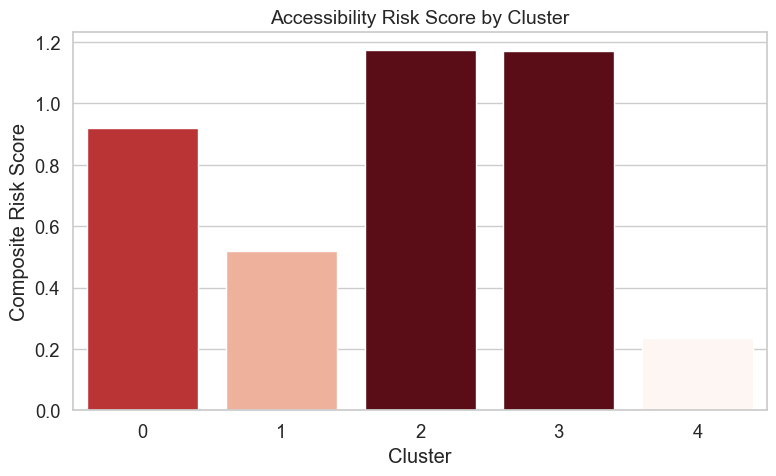

In [25]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=cluster_summary,
    x='agg_cluster',
    y='risk_score',
    palette='Reds',
    hue='risk_score'
)

plt.title("Accessibility Risk Score by Cluster", fontsize=14)
plt.xlabel("Cluster")
plt.ylabel("Composite Risk Score")
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

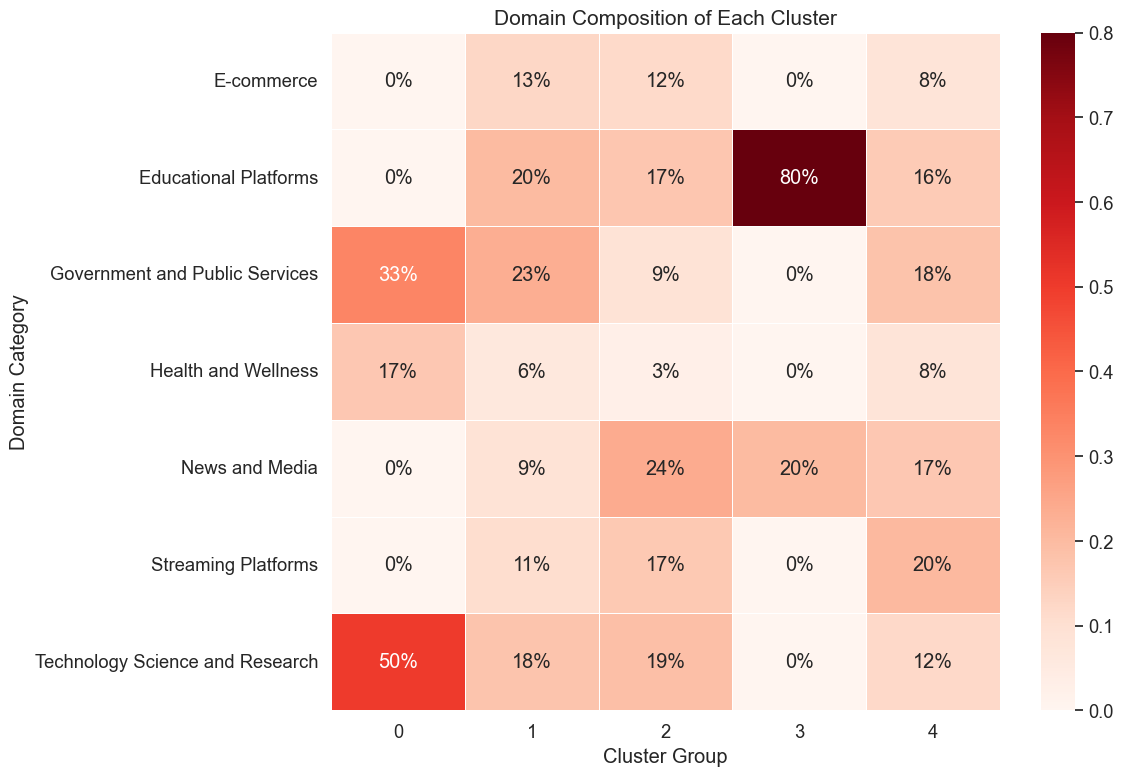

In [26]:
domain_categories = (
    df[['web_domain', 'domain_category']]
      .drop_duplicates(subset=['web_domain'])
      .set_index('web_domain')
)

merged_analysis = clustered.join(domain_categories)


category_risk = pd.crosstab(
    merged_analysis['domain_category'],
    merged_analysis['agg_cluster'],
    normalize='columns' 
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    category_risk,
    annot=True,
    fmt='.0%',
    cmap='Reds',
    linewidths=0.5
)
plt.title("Domain Composition of Each Cluster", fontsize=15)
plt.ylabel("Domain Category")
plt.xlabel("Cluster Group")
plt.tight_layout()
plt.show()


This heatmap helps us map these unlabeled clusters and attribute them to specific domain categories. Each column adds up to 100% and represents the proportion of clusters belonging to each domain category. In this we can observe that 80% of cluster 3 belongs to `Educational Platforms` and 50% of cluster 0 belongs to `Technology Science and Research`. However, this unusually high number may be attributed to cluster 0 and 3 being outliers.

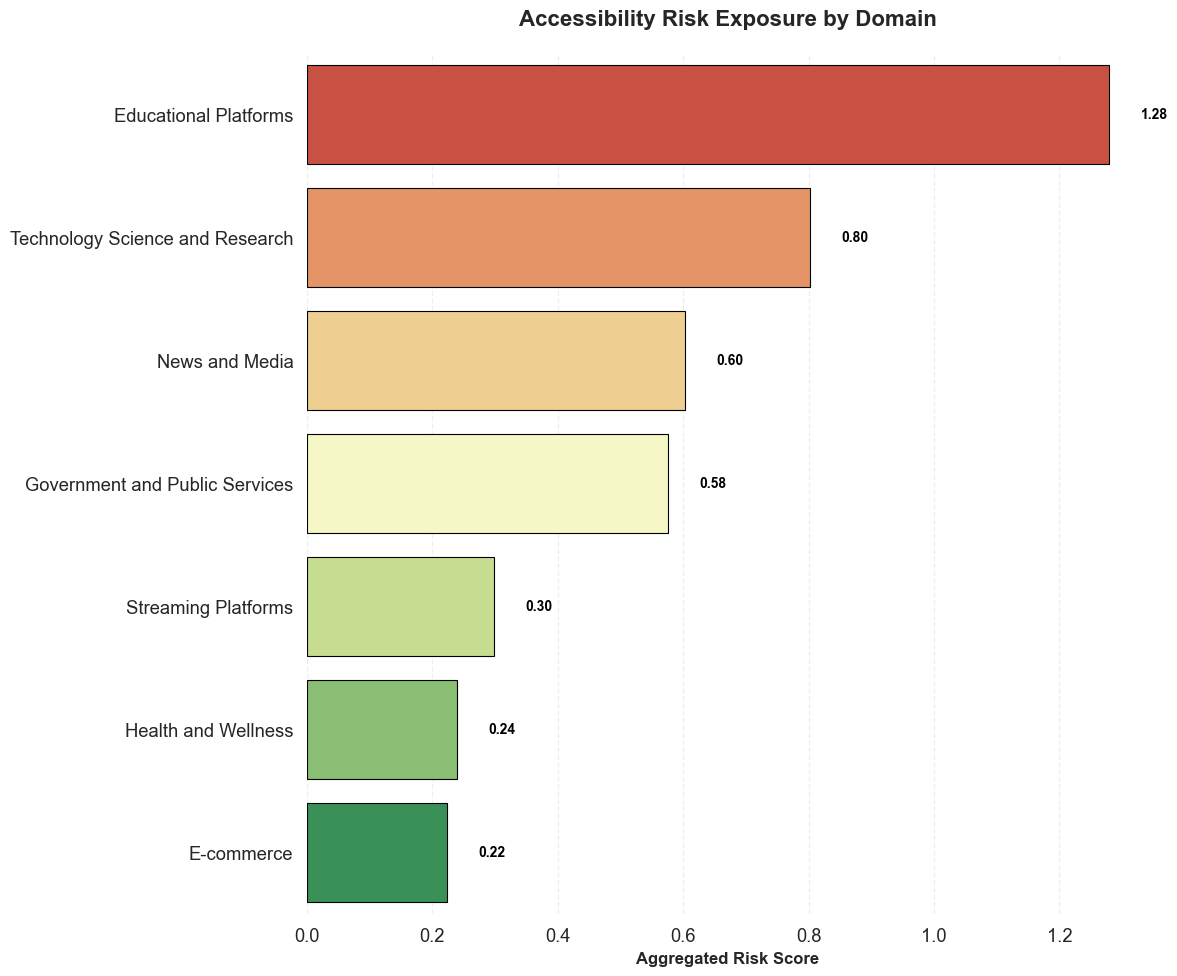

In [27]:
cluster_risk = cluster_summary['risk_score']

risk_weighted = category_risk.mul(cluster_risk, axis='columns')

domain_category_risk = (
    risk_weighted
    .sum(axis=1)
    .reset_index(name='aggregated_risk_score')
    .sort_values('aggregated_risk_score', ascending=False)
)

sorted_risk = domain_category_risk.sort_values(by='aggregated_risk_score', ascending=False)
plt.figure(figsize=(12, 10))

ax = sns.barplot(
    data=sorted_risk,
    x='aggregated_risk_score',
    y='domain_category', 
    hue='domain_category',    
    legend=False,             
    palette='RdYlGn',       
    edgecolor='black',
    linewidth=0.8
)

for i, v in enumerate(sorted_risk['aggregated_risk_score']):
    ax.text(v + 0.05, i, f"{v:.2f}", color='black', va='center', fontweight='bold', fontsize=10)

plt.title("Accessibility Risk Exposure by Domain", fontsize=16, fontweight='bold', pad=20)
plt.ylabel(None)
plt.xlabel("Aggregated Risk Score", fontsize=12, fontweight='bold')

sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

By consolidating the risk scores and heat map ratio between clusters and domain categories, we can build the risk profile for each domain categories. With no big surprised, `educational platforms` rank first followed by `Technology Science and Research` as second. Their presence in high-risk outlier clusters have proven them to be top contenders as high-risk domains that need to be watched out for!